In [1]:
from keras import losses, metrics
from keras.models import Sequential
from keras.models import Model, load_model
#from keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, sys, pickle
import pandas as pd
import random
import datetime

# 0. GPU setting

In [6]:
n_gpu = 3
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= f"{n_gpu}"  
print(datetime.datetime.now())

2022-09-08 00:26:50.417303


In [19]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


2022-01-15 23:21:33.400468: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-15 23:21:36.711660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-01-15 23:21:36.714741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30982 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2022-01-15 23:21:36.715454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU

# 1. Input loading

In [7]:
import pandas as pd
import numpy as np

BATCH_SIZE = 1024
MAX_CASES = 2000
SRATE = 100
LEN_INPUT = 60
OVERLAP = 0
LEN_PER_PRE = 60
LEN_PER_POST = 60
MODE = 'HR_mean'

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

rftn_train = np.load(input_path+'rftn_train.npz')['arr_0']
rftn_test = np.load(input_path+'rftn_test.npz')['arr_0']
rftn_val = np.load(input_path+'rftn_val.npz')['arr_0']

hr_train = np.load(input_path+'hr_train.npz')['arr_0']
hr_test = np.load(input_path+'hr_test.npz')['arr_0']
hr_val = np.load(input_path+'hr_val.npz')['arr_0']

hr_train_bin = hr_train > 0.25
hr_test_bin = hr_test > 0.25
hr_val_bin = hr_val > 0.25

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']
gender_val = np.load(input_path+'gender_val.npz', allow_pickle=True)['arr_0']

age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']
age_val = np.load(input_path+'age_val.npz', allow_pickle=True)['arr_0']

rftn_train = np.reshape(rftn_train, [-1,6000,1])
input_train = np.concatenate((x_train, rftn_train), axis=2)
rftn_test = np.reshape(rftn_test, [-1,6000,1])
input_test = np.concatenate((x_test, rftn_test), axis=2)
rftn_val = np.reshape(rftn_val, [-1,6000,1])
input_val = np.concatenate((x_val, rftn_val), axis=2)

print('done', flush=True)

print('input_train shape:', input_train.shape)
print('input_test.shape:', input_test.shape)
print(f'input_val.shape: {input_val.shape}\n')

print(f'hr_train : mean {hr_train.mean():.2f}, max {hr_train.max():.2f}, min {hr_train.min():.2f}')
print(f'hr_val : mean {hr_val.mean():.2f}, max {hr_val.max():.2f}, min {hr_val.min():.2f}')
print(f'hr_test : mean {hr_test.mean():.2f}, max {hr_test.max():.2f}, min {hr_test.min():.2f}')

print(datetime.datetime.now())

loading train...done
input_train shape: (796, 6000, 3)
input_test.shape: (98, 6000, 3)
input_val.shape: (87, 6000, 3)

hr_train : mean 0.21, max 0.89, min -0.29
hr_val : mean 0.24, max 0.88, min -0.22
hr_test : mean 0.21, max 0.88, min -0.19
2022-09-08 00:36:23.227219


### Validation

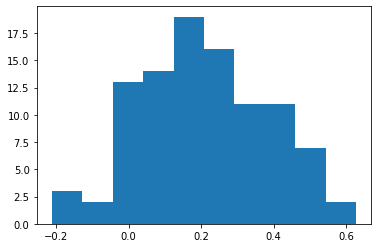

0.21101776


In [24]:
import matplotlib.pyplot as plt

plt.hist(hr_test)
plt.show()

print(hr_test.mean())

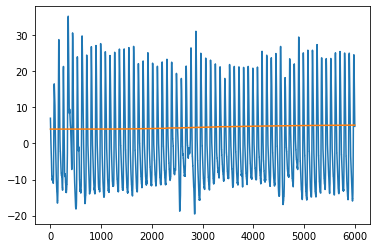

In [15]:
import matplotlib.pyplot as plt
plt.plot(x_test[57,:,0])
plt.plot(rftn_test[47,:])
#np.mean(x_val[2,:,1])

## Sample weight

In [14]:
train_w_samp = np.ones(shape=(len(hr_train),))
val_w_samp = np.ones(shape=(len(hr_val),))
test_w_samp = np.ones(shape=(len(hr_test),))
print(datetime.datetime.now())

2022-09-08 00:43:14.915726


In [9]:
print(np.sum(np.isnan(input_train)))
print(np.sum(np.isnan(input_test)))
print(np.sum(np.isnan(input_val)))

0
0
0


In [10]:
print(np.sum(np.isnan(x_train)), np.sum(np.isnan(rftn_train)), np.sum(np.isnan(hr_train)))

0 0 0


# 2. Model Training

In [22]:
from keras.models import Sequential
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


# hyperparamters
num_nodes = [128, 64] #, 64, 64, 64]
kernel_size = 3
pool_size = 2
BATCH_SIZE = 512
dense_node = 32
#dropout_rate = 0.3
dropout_cnn = 0.3
dropout_fc = 0.3
learning_rate = 0.002


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)


# 출력 폴더를 생성
model_name = 'EEG+PPG+RFTN_bin_'
for num_node in num_nodes:
    model_name += 'conv{}_'.format(num_node)
model_name += 'filter{}x2_tanh_bn_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}_kinit_kreg{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate, k_l2)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
root_path = f"output/CNN_{MODE}_ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}"
save_path = f"{root_path}/{model_name}"

if not os.path.exists(root_path):
    os.mkdir(root_path)

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1"])
#with strategy.scope():
with tf.device(f'/gpu:{n_gpu}'):
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        #model.add(LeakyReLU(alpha=0.1))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
        
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout_cnn))

    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh')) #, kernel_initializer=k_init, kernel_regularizer=k_reg))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid')) #kernel_initializer=k_init, kernel_regularizer=k_reg, activation='relu'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(input_train, hr_train_bin, sample_weight = train_w_samp, validation_data = (input_val, hr_val_bin, val_w_samp), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    tf.keras.backend.clear_session()


    # 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 모델의 history log 저장 - binary classification
history_list = []
for key in hist.history.keys():
    history_list.append({key:hist.history[key]})

# 모델의 history log 저장 - regression
pickle.dump(history_list, open(save_path+'/history','wb'))
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['mean_absolute_error'], hist.history['val_mean_absolute_error']), open(save_path+'/history', 'wb'))


'''
# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test) # binary는 flatten

# RMSE 계산
model_err = metrics.RootMeanSquaredError()
model_err.update_state(y_test, y_pred)
rmse_val = model_err.result().numpy()

# MAE 계산
model_err = metrics.MeanAbsoluteError()
model_err.update_state(y_test, y_pred)
mae_val = model_err.result().numpy()

print(f'test set RMSE: {rmse_val:.3f}, MAE: {mae_val:.3f}')
'''

model.load_weights(weight_path)
y_pred = model.predict(input_test).flatten()
# acc 계산
acc = metrics.Accuracy()
acc.update_state(y_pred, hr_test_bin, sample_weight=test_w_samp)
acc_val = acc.result().numpy()

# auroc 계산
false_positive_rate, true_positive_rate, threshold = roc_curve(hr_test_bin, y_pred, sample_weight=test_w_samp)
roc_auc = auc(false_positive_rate, true_positive_rate)

# auprc 
precision, recall, _ = precision_recall_curve(hr_test_bin, y_pred, sample_weight=test_w_samp)
prc_auc = auc(recall, precision)

# rename
os.rename(save_path, f'{root_path}/roc{roc_auc:.4f}_prc{prc_auc:.4f}_{model_name}_acc{acc_val:.2f}')

print(f'\ntest set acc {acc_val}, roc {roc_auc}, prc {prc_auc}')

print(datetime.datetime.now())

128-64


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 1.0533 - acc: 0.4460 - auc: 0.5043
Epoch 00001: val_loss improved from inf to 1.26491, saving model to output/CNN_HR_mean_ne60s-e60s-len60-0/EEG+PPG+RFTN_bin_conv128_conv64_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.3_dense32_dropout0.3_batch512_lr_0.002_kinit_kreg0/weights.hdf5
2/2 [==============================] - 4s 1s/step - loss: 1.0533 - acc: 0.4460 - auc: 0.5043 - val_loss: 1.2649 - val_acc: 0.4598 - val_auc: 0.4442
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.8183 - acc: 0.5302 - auc: 0.5024
Epoch 00002: val_loss improved from 1.26491 to 0.73947, saving model to output/CNN_HR_mean_ne60s-e60s-len60-0/EEG+PPG+RFTN_bin_conv128_conv64_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.3_dense32_dropout0.3_batch512_lr_0.002_kinit_kreg0/weights.hdf5
2/2 [==============================] - 1s 291ms/step - loss: 0.8183 - acc: 0.5302 - auc: 0.5024 - val_loss: 0.7395 - val_acc: 0.4943 - val_a

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6000, 64)          640       
                                                                 
 conv1d_1 (Conv1D)           (None, 6000, 64)          12352     
                                                                 
 activation (Activation)     (None, 6000, 64)          0         
                                                                 
 batch_normalization (BatchN  (None, 6000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3000, 64)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 3000, 64)          1

In [22]:
hist.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

### regression

In [ ]:
        model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error", tf.keras.metrics.AUC()])
        hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                            EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

### binary classification

In [ ]:
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_class, sample_weight = train_w_samp, validation_data = (x_val, y_val_class, val_w_samp), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

## Model history plot

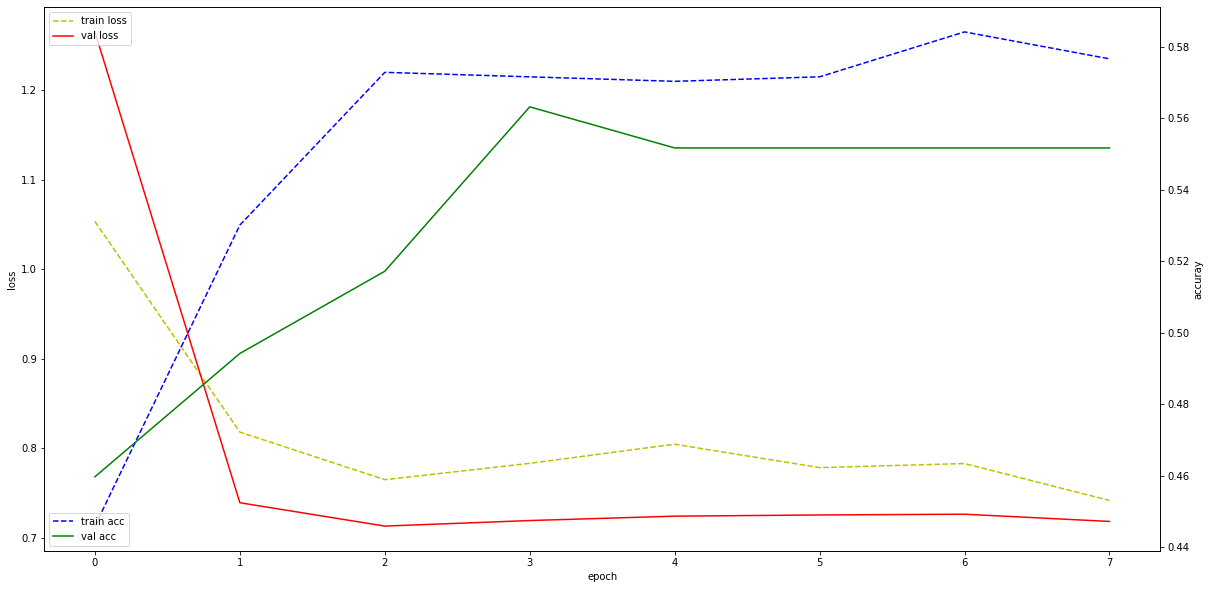

In [25]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()